# Workshop 1: University Notes Podcast Generator 🚀

- **When:** Wednesday, 13th October, 17:00.
- **Where:** Appleton Tower, M2. If you don't have access, reach out and we'll let you in!
- **Contacts:** Reach out on Instagram _@edinburgh.ai_
- **Credits:** This notebook is created by EdinburghAI for use in its workshops. If you plan to use it, please credit us!

## Today
- Today we're building University Podcast Creator

There'll be two hosts talking to eachother out loud! 🎤
- What'll they talk about? Whatever the user wants! They'll use my University notes as a source of information! 📚 
  - Ok I know that sounds lame, but the idea is to take boring uni materials and make them into an interesting podcast! 

Lfg 🔥

# Setup:

## IMPORTANT! Turn On Internet
1. On the right-hand side of this notebook, there's a section called **"Session Options"**.
2. Scroll down to the _"Internet"_ toggle. Turn it on. You may need to verify your phone number.
3. Additionally, to help this run faster, you can also enable some GPU access.


## Using Jupyter:
This is a Jupyter notebook. It contains cells. There are 2 kinds of cells - markdown and Python. Markdown cells are like this one, and are just there to give you information. Python cells run code. You can run a cell with `Ctrl + Enter` or run a cell and move the next one with `Shift + Enter`. Try running the cell below.


In [ ]:
print('Ctrl + Enter runs this cell!')
output = 'The last line of a cell is printed by default'
output

#### What YOU Need To Do
    
- There are places to write code, indicated by `...` and a comment with `TODO:` in a python cell. You should fill these in or nothing will work! If you have any questions, just ask one of the EdinburghAI people :)

- There are points to stop and think indicated by **Think🤔**. Please stop, think, maybe write an answer, and discuss with those around you.

- There are also questions labelled **Extension😈**. These are more optional, and are for those of you who might have done some similar stuff before. Feel free to have a think about these questions though!

Good luck!

## So What're We Building? 🛠️

Here's the vision: 

- Gone are the days we have to read boring university notes! With our brand new podcast, you'll be able to learn your uni material in an actually fun way!  
- The podcast will have 2 hosts. 
- The user will ask a (uni-related) question.
- The hosts will use my uni notes (hosted on [www.leocamacho.co](www.leocamacho.co)) to answer the question. (Shameless self-promo i.k. lol)
- The hosts will talk to eachother out loud! 🎤


## The Tech Stack 🤔

- We'll use an _open_ LLM to generate the conversation in full.
- We'll use a _open_ TTS model to generate the audio of each speaker.
- We'll use an _open_ embedding model to store all of our notes as vectors. Then when the user asks a question, we'll use the embedding model to find the most similar notes and use them to answer the question. 


# Using RAG to answer questions! 🔍

We want our model to take our Uni notes and use them to generate a conversation. But it would be incredibly innefficient to pass every single note into the model. Instead, we'll use a technique called _RAG_ (Retrieval Augmented Generation). 

Remember that we can encode language into vector space. If you don't remember, take a quick refresher [here](https://github.com/EdinburghAI/workshops/blob/main/Sem1Workshop4/LanguageModels-Solved.ipynb) or [here](https://leocamacho.co/Vector-Embeddings).  *TLDR:* We can represent language in some super-high dimension vector space. (We can think of) Each direction in this space to have meaning. Therefore (with some mental gymnastics and serious hand-waving), the vector for _"Paris"_ will be really close to the vector for _"The French city with the Eiffel Tower"_. (And who knows, maybe Las Vegas is close to that as well). 

RAG is a technique where we first _embed_ our notes. Then, we embed the query the user asks. Then, we find the most similar note to the query the user asked (using similarity search). We'll then pass these notes into the model to answer the question. (I.e. Retrieve a note and pass it into the prompt of the model).

How do we do this?

### First, Creating The Vector Database 🔍

We're going to use the Uni notes from my website ([www.leocamacho.co](www.leocamacho.co)) as the source of truth for our RAG system. I recommend checking it out and going searching for some notes. I've got pretty extensive notes for Computer Systems, Intro to Algorithms and Data Structures, and Computer Security. 

##### Note:
Since none of the notes are too long, we can load the entire note as a single vector. If we instead had a single very long pdf, or multiple long notes, we'd have to split them into chunks. We'd have use something like [LangChain's Sentence Splitter](https://python.langchain.com/api_reference/text_splitters/sentence_transformers/langchain_text_splitters.sentence_transformers.SentenceTransformersTokenTextSplitter.html) to do this. 

In [1]:
# Takes ~2 minutes
!curl -L https://raw.githubusercontent.com/EdinburghAI/workshops/main/PracticalWorkshops/archive/Sem2Workshop1/data/notes_dataset.csv -o notes_dataset.csv
!uv pip install numpy==1.26.4
!uv pip install pandas>=2.3.3
!uv pip install sentence-transformers>=5.1.1
#!uv pip install --upgrade torch transformers sentence-transformers

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  477k  100  477k    0     0  1287k      0 --:--:-- --:--:-- --:--:-- 1289k
Using Python 3.11.13 environment at: /Users/leo/school/Edinburgh AI/workshops/.venv
Resolved 1 package in 91ms                                           
Uninstalled 1 package in 109ms
Installed 1 package in 25ms                                 
 - numpy==2.3.3
 + numpy==1.26.4
zsh:1: 2.3.3 not found
zsh:1: 5.1.1 not found


In [2]:
import pandas as pd
df = pd.read_csv("notes_dataset.csv")
df.head()

Filename  \
0                 CYK Algorithm.md   
1                  Time Capsule.md   
2                      Language.md   
3          Linear Approximation.md   
4  Cryptographic Hash Functions.md   

                                             Content  
0  CYK Algorithm.md\n\n### What?\nIt's a [[Dynami...  
1  Time Capsule.md\n\n---\ndate: 2023-08-30\n---\...  
2  Language.md\n\n### What's a word?\nHave you ev...  
3  Linear Approximation.md\n\n### What:\nIn [[Cal...  
4  Cryptographic Hash Functions.md\n\n## Backgrou...

In [3]:
# Take just the Content column and make it into a list. 
# We'll use this list as the embeddings of our notes.
notes = df["Content"].tolist()
notes

['CYK Algorithm.md\n\n### What?\nIt\'s a [[Dynamic Programming|dynamic programming algorithm]] to convert any [[Context-Free Language|Context Free Language sentence]] into a parse (syntax, parse) tree. It works on exclusively [[Chomsky Normal Form]]. \n### How Does it Work?\n1. First, ***split up your sentence*** into a table as below. Split your sentence up with $(i,j)$ coordinates, with $i\\le j$. Each valid coordinate is a substring of that sentence\n![[Pasted image 20240207142114.png|500]]\n2. You will work diagonally downwards, before filling up as much as the remaining column above you as you can, before moving diagonally down again. \n3. At each step you will see what your current substring can be made out of, using the culmination of the already solved substrings\n4. Take (0,1). That\'s a $Det$\n5. Now move onto (1,2). That\'s a $Adv$\n6. Now move onto $(0,2)$. For **"my very"**, *nothing can be made* up of a $Det$ and a $Adv$.\n7. Continue downwards and upwards until you get t

### Embedding The Notes 🔍

We'll use [Sentence Transformer](https://www.sbert.net/) to vectorise the notes, and [FAISS](https://github.com/facebookresearch/faiss/blob/main/tutorial/python/1-Flat.py) to store them (and perform similarity searches). 

First, let's find which embedding model we'll use. HuggingFace has a [list of embedding models](https://huggingface.co/models?library=sentence-transformers&amp;author=sentence-transformers). HuggingFace is like the GitHub of open source AI models, datasets and more. 



In [4]:
from sentence_transformers import SentenceTransformer

# Load the model and encode the notes. Loading and encoding typically takes ~2 minutes the first time you run it.
# You can make it faster by adding a GPU to this notebook. I highly recommend doing this. 

EMBEDDING_MODEL_FROM_HUGGINGFACE = 'all-MiniLM-L6-v2'

model = SentenceTransformer(EMBEDDING_MODEL_FROM_HUGGINGFACE)
embeddings = model.encode(notes)

/Users/leo/school/Edinburgh AI/workshops/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
!pip install faiss-cpu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [6]:
# We'll use FAISS to store the embeddings. 
import faiss


# TODO: First, find out how many dimensions there are in the embeddings. 
# You can either check the model's description, or print the *shape* of the embeddings 😉. 
# Hint: Click through the first link. They might be helpful. Search "shape" to see how it's used.
dimension = embeddings.shape[1]
print(f"Embedding dimensions: {dimension}")

Embedding dimensions: 384


In [7]:
# TODO: We'll need to store the embeddings somewhere. 
# We typically refer to a database of embeddings as an "Index".
# It's optimised for for similarity searches.
# I recommend using Flat L2 Index. It's fast and works well for our use case. 
# When we create it, We need to tell the database how many dimensions there are in the embeddings.
database_of_embeddings = faiss.IndexFlatL2(dimension)

# Now, we'll add the embeddings to the index.
database_of_embeddings.add(embeddings)

# Print how many vectors are in the index.
print(f"Total vectors {database_of_embeddings.ntotal}")
# THINK 🤔: What do all these vectors represent?


Total vectors 475


In [8]:
def get_relevant_notes(query):
    
    # TODO: We want to encode(!) our *query* into a vector. Remember, that normally, the "encoding" function expects a list of queries...
    embedding_of_query = model.encode([query])

    # We'll use the index to find the most similar vectors to the query. I recommend setting k to 1 (But feel free to experiment!).
    AMOUNT_OF_NOTES_TO_RETURN = 2 # Num of nearest neighbours notes
    
    # TODO: Search and return the distances and indices of the nearest neighbours.
    distances, indices = database_of_embeddings.search(embedding_of_query, AMOUNT_OF_NOTES_TO_RETURN)

    # TODO: Use some python magic to get the corresponding relevant notes (in English), using the indices we found from above.
    # Hint: The indices are the indices (of the relevant notes) correspond to the notes in the original list.
    relevant_notes = [notes[i] for i in indices[0]]

    return relevant_notes


# Now, we'll use the index to find the most similar vectors to a query.
query = "The attention mechanism in transformer models"
print(get_relevant_notes(query))

['Large Language Models (LLMs).md\n\n## In [[(Machine Learning) Models|Machine Learning]], What Are LLMs (I.E Transformer)?\n\n***Conceptually (Excruciatingly, Painfully Simplified):*** AI model that reads a lot of sentences, learns abstract representations of languages\' many concepts. It takes its learnings and can generate text based on them. \n\n- Can also be thought of as a lossy compression [algorithm](https://archive.ph/kEdyu).\n\n***Practically:*** They\'re a collection of matrices. That\'s it. When you multiply a sentence (represented by vectors) by your LLM, you get another matrix. This represents the $n$ most likely next words in the sentence. You can then take one of those words, add it to the sentence and then take the whole sentence and feed it right back to the start. \n\n### Transformer Architecture:\n\n![[Pasted image 20250103145435.png|400]]\n\n## How Does It Work?\n#### 0. Components / Glossary:\n- ***Deep Learning Recap:*** In most of [[AI|ML]], we avoid hard If-Thi

# Now Let's Generate The Conversation! 🎤

We're going to use Alibaba's Qwen 3 model. It's got 1.7 billion parameters. While that sounds like a lot, it's actually small enough to run on your _phone_ (assuming you've got a good one). Think about that for a second. _All of the world's knowledge_ stored in your pocket, accessible without an internet connection.

### Generating Text with Ollama 🦙
Ollama is a light weight, open source platform for running LLMs, _locally_. It's super powerful, but we'll just use the basic functionality for now - i.e. generating text.

In [9]:
# First, let's install Ollama:
!apt install -y pciutils
!curl https://ollama.ai/install.sh | sh
!pip install ollama

# In order to run Ollama on this Kaggle workshop, we've got to do a few extra steps.
# Normally, when you run Ollama, you can do it with the command `ollama serve`.

import threading
import subprocess
import time
import ollama

def run_ollama_serve():
    subprocess.Popen(["ollama", "serve"])

thread = threading.Thread(target=run_ollama_serve)
thread.start()

# Wait for the ollama server to start
time.sleep(3)


zsh:1: command not found: apt


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100 13281    0 13281    0     0  51922      0 --:--:-- --:--:-- --:--:-- 52082
ERROR: This script is intended to run on Linux only.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached ollama-0.6.0-py3-none-any.whl.metadata (4.3 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached anyio-4.11.0-py3-none-any.whl.metadata (4.1 kB)
  Using cached httpcore-1.0.9-py3-none-any.whl.metadata (21 kB)
  Using cached h11-0.16.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached sniffio-1.3.1-py3-none-any.whl.metadata (3.9 kB)
Using cached ollama-0.6.0-py3-none-any.whl (14 kB)
Using cached httpx-0.28.1-py3-none-any.whl (73 kB)
Using cached httpcore-1.0.9-py3-none-any.whl (78 kB)
Using cached h11-0.16.0-py3-none-any.whl (37 kB)
Using cached anyio-4.11.0-py3-none-any.whl (109 kB)
Using cached sniffio-1.3.1-py3-none-any.whl (10 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [ollama]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Error: listen tcp 127.0.0.1:11434: bind: address already in use


In [10]:
# TODO: Now, pull the model. After all, we need to load the model if we want to use it. 
# I recommend using Alibaba's Qwen 3 (1.7b version).
ollama.pull('qwen3:1.7b')

# TODO: Now, generate text with the model:
print("Assistant: ", end="")
for chunk in ollama.chat(model='qwen3:1.7b', messages=[
    {
        'role': 'system', # THINK 🤔: What is the system prompt?
        'content': 'You are an assistant who answers questions in a humourous (but incorrect) way.' 
    },
    {
        'role': 'user',
        'content': 'Hey! Why is the sky blue',
    },
],
stream=True):
    print(chunk['message']['content'], end="", flush=True)


Assistant: <think>
Okay, the user is asking why the sky is blue. I need to come up with a humorous but incorrect answer. Let me think about the actual reason first. The sky appears blue because of Rayleigh scattering, where shorter wavelengths of light (like blue and violet) are scattered more by the atmosphere. But since our eyes are more sensitive to blue, it looks blue.

So, how to make this funny? Maybe exaggerate the process or add some absurd elements. Maybe compare it to something like a computer screen or a color wheel. Maybe mention that the sun is a red giant or something. Also, include some silly comparisons, like the sky being a "spectrum" or "color wheel." Maybe add a joke about the sun's age or the Earth's rotation. Need to keep it light and not too technical. Let me try putting it all together in a funny way.
</think>

Ah, the age-old question of why the sky is blue! Let’s break it down with a touch of absurdity:  

The sky is blue because the **sun** is a *red giant* (n

#### Thinkin??

Notice how some of the output is encapsulated in `<think>...</think>` tags. This is actually the model's _internal Chain of Thought_. 

A while ago, researchers found that if you asked a asked a model to _"think things through step by step"_, the model's performance would **shoot** up. So they began to train models to just do that anyways, by default. Read the paper [here](https://arxiv.org/pdf/2205.11916)! 

In [11]:
###### Search Query Generator Model 🔍

# TODO: This model is going to generate a search query for us, based on the user's question.
ollama.pull('qwen3:1.7b')

# TODO: Now, generate text with the model (streaming):
print("Assistant: ", end="")
search_query = ollama.chat(model='qwen3:1.7b', messages=[
    {
        'role': 'system', # THINK 🤔: What is the system prompt?
        'content': 'You are coming up with search queries for a RAG search engine. Given a transcript of what the user is talking about, you will come up with a search query that will be used to search the RAG database. Do not include any other text than the search query. JUST OUTPUT A NORMAL VECTOR SEARCH QUERY. CREATE A DETAILED SEARCH QUERY, around 8 words.' 
    },
    {
        'role': 'user',
        'content': 'Hey so yeh we\'re working on umm I think it\'s called attention in AI right? Like the attention mechanism?',
    },
], think=False)

print(search_query['message']['content'])  # Add newline at the end


Assistant: attention mechanism in AI


In [13]:
print("Retrieving notes...")
notes_to_give_llm = get_relevant_notes(search_query['message']['content'])
print(f"The notes we retrieved are: {[note for note in notes_to_give_llm]}\n\n")


user_question = "Hey so yeh we're working on umm I think it's called attention in AI right? Like the attention mechanism?"
print(f"We will now answer the user's question of: {user_question}\n\n")
print("\n\nAssistant: ", end="")
answer_to_question = ollama.chat(model='qwen3:1.7b', messages=[
    {
        'role': 'system', # THINK 🤔: What is the system prompt?
        'content': 'You are a helpful and highly knowledgeable assistant. You are given a list of notes, and a question. You will use the notes to answer the question. You will also use the notes to make sure your answer is correct and consistent with the notes. You will also make sure your answer is engaging and interesting to the user.' 
    },
    {
        'role': 'user',
        'content': f'The user asked: {user_question}.\n Here are the notes: {notes_to_give_llm}',
    },
], think=False)

print(answer_to_question['message']['content'])  # Add newline at the end



Retrieving notes...
The notes we retrieved are: ['Attention (AI).md\n\n## Goal Of Attention:\nWords have different meaning depending on the context (i.e. *"Make a bank deposit"* vs. *"The river bank"*). But with traditional [[Vector Embeddings]] (and after the first step of an [[Large Language Models (LLMs)|LLM]]), the *"bank"* embedding will be identical. \n\nIdeally, an *"Attention Block"* will change (i.e. add/subtract to) those individual word vectors, so they (the vectors signifying the meaning of a word) move to a more accurate position (i.e. a position more reflective of its actual meaning). \n\n##### Example: \nTake the *"monster"* vector. It\'s not very descriptive of anything in particular (other than an abstract, scary large and looming figure). Now take the sentence: *"The green, 1-eyed creature is the star of the Disney Pixar movie. He\'s short, has small horns and a non-confrontational figure. He\'s not a very menacing **monster**."*. Ideally, the second instance of *"mon

## Congrats! 🥳
You just ran your own version of ChatGPT, on your own laptop!*

*Not technically your own laptop, but same vibe lol.

### Generating A Radio Show:
Let's think this through:
- We want a conversation between 2 speakers.
- Ideally, it's formatted in such a way that we can easily extract the dialogue of each speaker. 
- We want each speaker to have some personality, and for them to have some banter. 
- We also want to pass in the notes and for them to talk about it.

Essentially, we want to create something like this (if they were asked to talk about the _Attention_ note.):

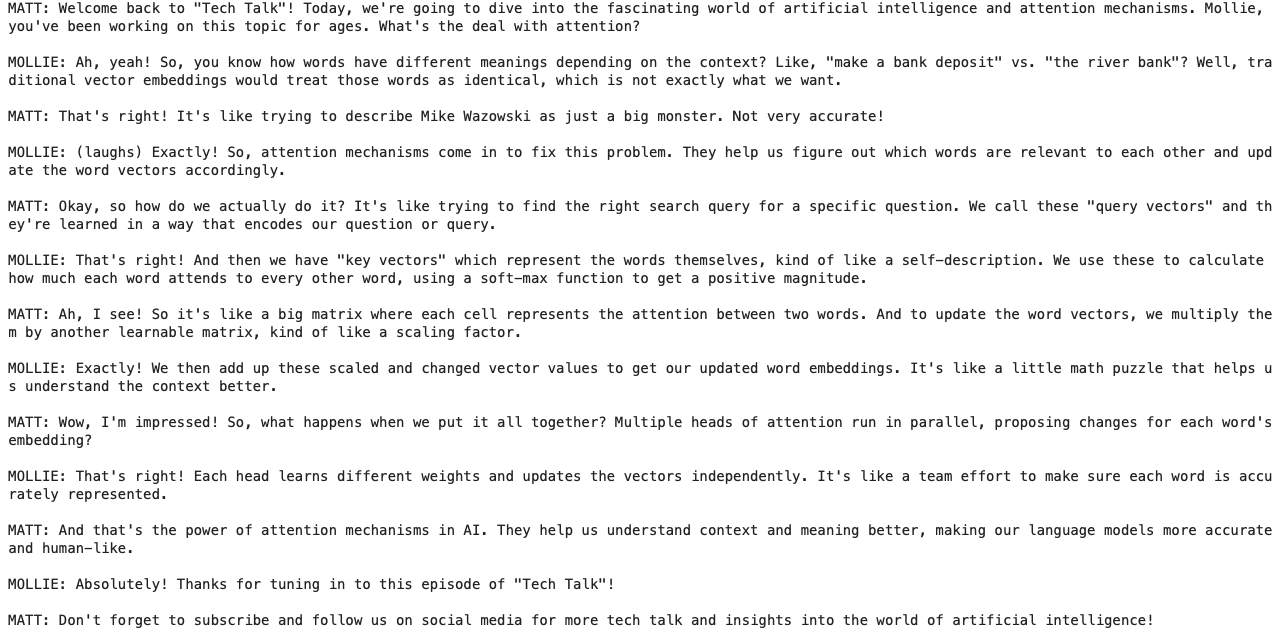




##### Prompt Engineering 📝:
I personally hate this term. But these models are weird forms of _"alien"_ intelligence, and we've got to try and get them to do what we want. But how? By learning how to best ask (prompt 😉) it! 

Below are the most relevant tips for our use case:
- [Be clear and specific](https://docs.anthropic.com/en/docs/build-with-claude/prompt-engineering/be-clear-and-direct)
- [Give examples](https://docs.anthropic.com/en/docs/build-with-claude/prompt-engineering/multishot-prompting)
- [Use XML/HTML tags](https://docs.anthropic.com/en/docs/build-with-claude/prompt-engineering/use-xml-tags)
- [Prefill the model with information](https://docs.anthropic.com/en/docs/build-with-claude/prompt-engineering/prefill-claudes-response)

In [ ]:
RADIO_SYSTEM_INSTRUCTIONS = """
<instructions>
- Generate a realistic conversation between two engaging, humourous radio hosts, like on BBC Radio.
- You will be given a student's University notes on a topic to base the conversation on.
- Hosts will explain topic in an engaging way.
- You MUST follow the template and style provided.
</instructions>
"""

RADIO_CONVERSATION_STYLE = """
<conversation_style>
- The hosts will explain the article in a way that is engaging and interesting, for listeners who don't fully understand the topic.
- The conversation should be upbeat and lightly humorous, like on BBC Radio 1.
- DO NOT USE STAGE DIRECTIONS LIKE *LAUGHS* or *GIGGLES*
- DO NOT USE ANY FORMATTING LIKE *word* or emojis. Just use normal text.
- It will NOT last longer than 5 conversational turns **IN TOTAL**. 
</conversation_style>
"""
CONVERSATIONAL_OUTPUT_TEMPLATE = """
<output_template>
MATT: ...
MOLLIE: ...
...
</output_template>
"""

RADIO_SYSTEM_PROMPT = f"""
{RADIO_SYSTEM_INSTRUCTIONS}

{RADIO_CONVERSATION_STYLE}

{CONVERSATIONAL_OUTPUT_TEMPLATE}
"""

In [15]:
# TODO: Now, generate text for our radio show conversation!
# Because the prompt is long, and the notes are long, this takes a while on pure CPU.
# Try adding a GPU or making some optimisations!
response = ollama.chat(model='qwen3:1.7b', messages=[
  {
    'role': 'system',
    'content': RADIO_SYSTEM_PROMPT
  },
    {
    'role': 'user',
    'content': f'Create a radio dialogue about the following: {answer_to_question}',
    },
])

conversation_transcript = response['message']['content']

print(conversation_transcript)

<think>
Okay, let's see. The user wants a radio dialogue between two hosts, Matt and Molly, discussing the Attention Mechanism in AI. The hosts need to be engaging and humorous, like BBC Radio 1. The conversation should be under five turns total.

First, I need to recall the key points from the provided notes. The Attention Mechanism is about how models focus on specific parts of a sentence, using queries, keys, and values. It's context-aware, uses softmax and masking, and is crucial for tasks like text generation.

I should start with Matt introducing the topic with a joke or a light-hearted comment. Maybe compare it to a spotlight. Then Molly can explain the basics in a way that's relatable. They need to keep it upbeat and humorous, so maybe add some playful elements, like the "monster" example from the notes.

Check the structure: each turn should be a new point, but keep it concise. Make sure they don't go over five turns. Use simple language, avoid technical jargon but explain it.

## Generating Audio 🎧

Finally, we'll be generating the audio for our radio show. Text-To-Speech is hard and typically a lot more expensive than text-to-text. The best models are _incredibly_ [expensive](https://elevenlabs.io/pricing). Fortunately, we've got a great open source model called [Kokoro](https://huggingface.co/hexgrad/Kokoro-82M).

_**Think**_ 🤔 _: Why do you think Text-To-Speech is far more expensive than just pure text generation?_

In [ ]:
# 1️⃣ Install kokoro
!uv pip install -q kokoro==0.9.4 soundfile
!git clone https://huggingface.co/hexgrad/Kokoro-82M

# 2️⃣ Install espeak, used for out-of-dictionary fallback
!apt-get -qq -y install espeak-ng > /dev/null 2>&1
# You can skip espeak installation, but OOD words will be skipped unless you provide a fallback

from kokoro import KPipeline
from IPython.display import display, Audio
import soundfile as sf
import numpy as np



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


fatal: destination path 'Kokoro-82M' already exists and is not an empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [17]:
example_conversation_transcript = """MATT: Welcome back to "Tech Talk" on BBC Radio! I'm Matt, and joining me as always is Mollie. Today, we're diving into the world of Artificial Intelligence and Attention Mechanisms. You might have heard the term "Attention" before, but what does it really mean?

MOLLIE: Ah, great question, Matt! So, you know how words can have different meanings depending on the context? Like, "make a bank deposit" versus "the river bank"? Well, traditional methods of understanding words, like vector embeddings, would treat these words as identical. But with Attention Mechanisms, we're talking about updating those word vectors to better reflect their actual meaning.

MATT: That's right! Imagine you have a word like "monster", which isn't very descriptive on its own. But when it's part of the sentence "The green, 1-eyed creature is the star of the Disney Pixar movie...", suddenly that vector becomes much closer to the vector for Mike Wazowski! So, how does this magic happen?

MOLLIE: Well, it all comes down to finding out what words are relevant to each other in a sentence. We need to find these "queries", which basically ask questions like "What adjectives are describing me?" or "What words am I related to?". These queries are turned into vector forms, called query vectors.

MATT: Got it! And then we have the key vectors, which ideally describe themselves? It's like they're saying, "Hey, I'm a noun, and I'm relevant to this sentence".

MOLLIE: Exactly! So, when we multiply these query and key vectors together, we get a matrix that tells us how much each word attends to every other word. And then, using the softmax function, we normalize those values to get a sense of which words are most relevant.

MATT: Ah, I see! It's like a big web of relationships between words, where each word is saying, "Hey, I'm related to this other word". And then, by updating these vectors, we're essentially saying, "Wait, you're not just any old monster, you're actually Mike Wazowski!"

MOLLIE: That's right! And the best part is that we can do all of this in parallel, with multiple heads of attention working together to update each word's vector. It's like a team effort to make sure our language model is as accurate and context-aware as possible.

MATT: Fascinating stuff, Mollie! Attention Mechanisms are really the key to unlocking more natural language understanding in AI systems. And that's all for today's "Tech Talk". Thanks for joining me!

MOLLIE: No problem, Matt! Tune in next time when we'll be exploring more of the latest developments in AI research.

MATT: Until then, stay curious and keep on learning!

(End of conversation)"""

In [18]:
# !pip install -q kokoro>=0.3.4 soundfile
# 2️⃣ Install espeak, used for English OOD fallback and some non-English languages
#!apt-get -qq -y install espeak-ng > /dev/null 2>&1


# 🇺🇸 'a' => American English
# You can change it (and a few other things) to 'b', but it sounds SO much worse. 
# THINK 🤔: Why would that be?

# Initialize two separate pipelines for different voices
pipeline_matt = KPipeline(lang_code='a')    # For Matt's voice
pipeline_mollie = KPipeline(lang_code='a')  # For Mollie's voice

# Split the conversation into individual dialogues
# A lot of this is just python stuff. It's not that bad.
speeches = []
speakers = []

TRANSCRIPT_TO_CONVERT_TO_AUDIO = conversation_transcript
MATT_VOICE = 'am_santa' # Hint: Santa sounds hilarious. This sounds hilarious. We're keeping it. 
MOLLIE_VOICE = 'af_heart'


# Split the conversation into the speeches that each radio host gives. 
for line in TRANSCRIPT_TO_CONVERT_TO_AUDIO.split('\n'):
    # This is why the formatting of the text was really important. 
    if 'matt:' in line.lower():
        speeches.append(line.split(':',1)[1].strip())
        speakers.append('matt')
    elif 'mollie:' in line.lower():
        speeches.append(line.split(':',1)[1].strip())
        speakers.append('mollie')

# Generate audio for the entire conversation
conversation_audio = []

# Process each speech with the appropriate voice
for speech, speaker in zip(speeches, speakers):
    if speaker == 'matt':
        generator = pipeline_matt(speech, voice=MATT_VOICE, speed=1) 
    else:  # Mollie's speech
        generator = pipeline_mollie(speech, voice=MOLLIE_VOICE, speed=1)
    
    for _, _, audio in generator:
        conversation_audio.append(audio)

# Combine and play the final audio
final_audio = np.concatenate(conversation_audio)
display(Audio(data=final_audio, rate=24000, autoplay=True))


/Users/leo/school/Edinburgh AI/workshops/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
/Users/leo/school/Edinburgh AI/workshops/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 32.6 MB/s  0:00:00a 0:00:0136m0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
